## CS 543 MP3 Part 2
### Fundamental Matrix, Camera Caliberation and Triangulation

In [134]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [5]:
data_dir = 'C:/Users/Rachneet Kaur/Desktop/UIUC/UIUC Spring 2019/CS 543 CV/MP3/MP3_part2_data/'

## First pair of images

In [79]:
##
## load images and match files for the first example
##

I1 = Image.open(data_dir+'library1.jpg');
I2 = Image.open(data_dir+'library2.jpg');
matches = np.loadtxt(data_dir+'library_matches.txt'); 

# this is a N x 4 file where the first two numbers of each row
# are coordinates of corners in the first image and the last two
# are coordinates of corresponding corners in the second image: 
# matches(i,1:2) is a point in the first image
# matches(i,3:4) is a corresponding point in the second image

N = len(matches)

In [505]:
#Part 1
#Function to compute the fundamental matrix
def fit_fundamental(matches_, normalized):
    if normalized==1:
        print ('Normalized Method')
        #Fundamental matrix using normalized method
        N = matches_.shape[0]
        left = matches_[:, 0:2]
        right = matches_[:, 2:4]
        left_mu_x, left_mu_y = left.mean(axis = 0)
        right_mu_x, right_mu_y = right.mean(axis = 0)
        scaled_left = left - [left_mu_x, left_mu_y]
        scaled_right = right - [right_mu_x, right_mu_y]
        scaled_msd_left = np.sqrt((scaled_left[:,0]**2+scaled_left[:,1]**2).sum()/(2*N))
        scaled_msd_right = np.sqrt((scaled_right[:,0]**2+scaled_right[:,1]**2).sum()/(2*N))
        normalized_left = scaled_left/scaled_msd_left
        normalized_right = scaled_right/scaled_msd_right
        u =normalized_left[:, 0]
        v = normalized_left[:, 1]
        u1 = normalized_right[:, 0]
        v1 = normalized_right[:, 1]
        col1 = np.multiply(u, u1).reshape(-1,1)
        col2 = np.multiply(u1, v).reshape(-1,1)
        col3 = u1.reshape(-1,1)
        col4 = np.multiply(v1, u).reshape(-1,1)
        col5 = np.multiply(v1, v).reshape(-1,1)
        col6 = v1.reshape(-1,1)
        col7 = u.reshape(-1,1)
        col8 = v.reshape(-1,1)
        col9 = np.ones((N,1))
        #Computing the coefficient matrix to solve for Fundamental matrix
        A = np.hstack((col1, col2, col3, col4, col5, col6, col7, col8, col9))
        #To solve for homogeneous system, we take the eigenvector of A^T.A cooresponding to the smallest eigenvalue
        U, S, V = np.linalg.svd(A) 
        #Eigenvector correponding to the smallest eigenvalue of A^T.A
        F_col = V[S.argmin()] #Fundamental matrix in array format
        F = F_col.reshape(3,3) #3X3 Fundamental matrix

        #Enforcing the rank-2 constraint - Taking SVD of F and zeroing the smallest singular value
        F_U, F_S, F_V = np.linalg.svd(F) 
        F_S[F_S.argmin()] = 0 #Setting the smallest singular value to be 0
        #Reconstructing the fundamental matrix F
        F_normalized = np.matmul(np.matmul(F_U, np.diag(F_S)), F_V)
        
        #Transforming F to original coordinates 
        T = np.array([[1./scaled_msd_left, 0, 0], [0, 1./scaled_msd_left, 0], [-left_mu_x/scaled_msd_left, -left_mu_y/scaled_msd_left, 1]])
        T1 = np.array([[1./scaled_msd_right, 0, 0], [0, 1./scaled_msd_right, 0], [-right_mu_x/scaled_msd_right, -right_mu_y/scaled_msd_right, 1]])
        Fmatrix = np.matmul(np.matmul(T1, F_normalized), T.T)
    
    else:
        print ('Unnormalized Method')
        #Fundamental matrix using unnormalized method
        u = matches_[:, 0]
        v = matches_[:, 1]
        u1 = matches_[:, 2]
        v1 = matches_[:, 3]
        col1 = np.multiply(u, u1).reshape(-1,1)
        col2 = np.multiply(u1, v).reshape(-1,1)
        col3 = u1.reshape(-1,1)
        col4 = np.multiply(v1, u).reshape(-1,1)
        col5 = np.multiply(v1, v).reshape(-1,1)
        col6 = v1.reshape(-1,1)
        col7 = u.reshape(-1,1)
        col8 = v.reshape(-1,1)
        N = matches_.shape[0]
        col9 = np.ones((N,1))
        #Computing the coefficient matrix to solve for Fundamental matrix
        A = np.hstack((col1, col2, col3, col4, col5, col6, col7, col8, col9))
        #To solve for homogeneous system, we take the eigenvector of A^T.A cooresponding to the smallest eigenvalue
        U, S, V = np.linalg.svd(A) 
        #Eigenvector correponding to the smallest eigenvalue of A^T.A
        F_col = V[S.argmin()] #Fundamental matrix in array format
        F = F_col.reshape(3,3) #3X3 Fundamental matrix

        #Enforcing the rank-2 constraint - Taking SVD of F and zeroing the smallest singular value
        F_U, F_S, F_V = np.linalg.svd(F) 
        F_S[F_S.argmin()] = 0 #Setting the smallest singular value to be 0
        #Reconstructing the fundamental matrix F
        F_unnormalized = np.matmul(np.matmul(F_U, np.diag(F_S)), F_V)
        Fmatrix = F_unnormalized   
    return Fmatrix

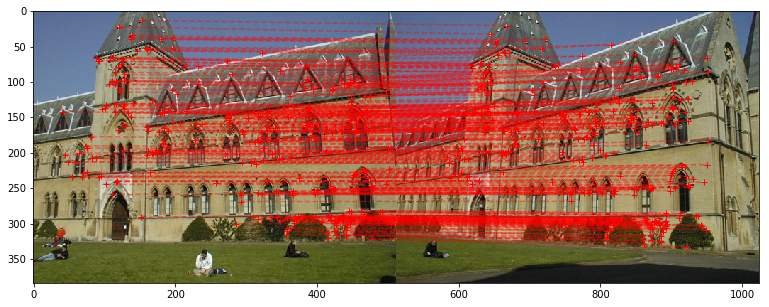

In [514]:
##
## display two images side-by-side with matches
## this code is to help you visualize the matches, you don't need
## to use it to produce the results for the assignment
##
%matplotlib inline
I3 = np.zeros((I1.size[1],I1.size[0]*2,3) )
I3[:,:I1.size[0],:] = I1;
I3[:,I1.size[0]:,:] = I2;
fig, ax = plt.subplots(figsize = (13,13))
ax.set_aspect('equal')
ax.imshow(np.uint8(np.array(I3)))
ax.plot(matches[:,0],matches[:,1],  '+r')
ax.plot( matches[:,2]+I1.size[0],matches[:,3], '+r')
ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r--', alpha = 0.4)
plt.show()


Unnormalized Method


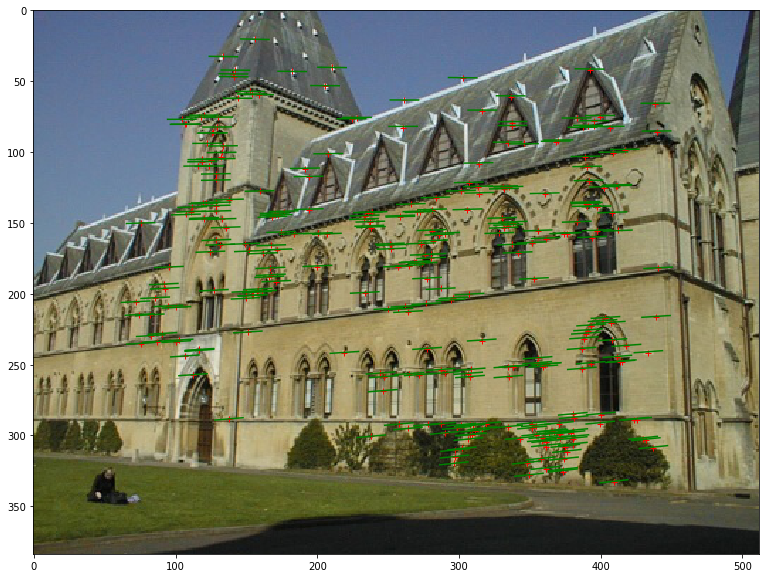

Library Image 1 - Unnormalized method residual =  0.17921336680315691


In [516]:
##
## display second image with epipolar lines reprojected 
## from the first image
##
# first, fit fundamental matrix to the matches

# FOR THE UNNORMALIZED FUNDAMENTAL MATRIX
F = fit_fundamental(matches, 0); # this is a function that you should write
M = np.c_[matches[:,0:2], np.ones((N,1))].transpose()
L1 = np.matmul(F, M).transpose() # transform points from 
# the first image to get epipolar lines in the second image

# find points on epipolar lines L closest to matches(:,3:4)
l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())# rescale the line
pt_line_dist = np.multiply(L, np.c_[matches[:,2:4], np.ones((N,1))]).sum(axis = 1)
closest_pt = matches[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())

# find endpoints of segment on epipolar line (for display purposes)
pt1 = closest_pt - np.c_[L[:,1], -L[:,0]]*10# offset from the closest point is 10 pixels
pt2 = closest_pt + np.c_[L[:,1], -L[:,0]]*10

# display points and segments of corresponding epipolar lines
fig, ax = plt.subplots(figsize = (13,13))
ax.set_aspect('equal')
ax.imshow(np.uint8(np.array(I2)))
ax.plot(matches[:,2],matches[:,3],  '+r')
ax.plot([matches[:,2], closest_pt[:,0]],[matches[:,3], closest_pt[:,1]], 'r')
ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')
plt.show()

#Residual using unnormalized method 
print ('Library Image 1 - Unnormalized method residual = ',(pt_line_dist**2).mean())

Normalized Method


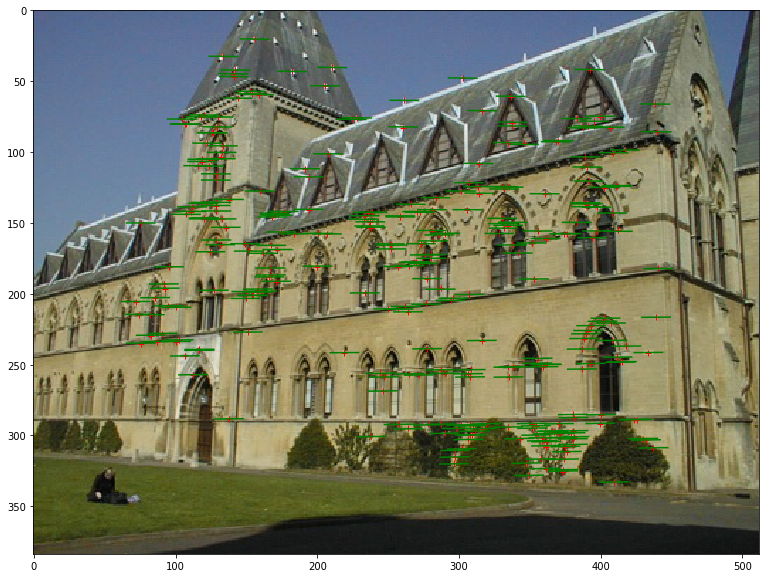

Library Image 1 - Normalized method residual =  0.06025105258204129


In [517]:
### FOR THE NORMALIZED FUNDAMENTAL MATRIX
F = fit_fundamental(matches, 1); # this is a function that you should write
M = np.c_[matches[:,0:2], np.ones((N,1))].transpose()
L1 = np.matmul(F, M).transpose() # transform points from 
# the first image to get epipolar lines in the second image

# find points on epipolar lines L closest to matches(:,3:4)
l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())# rescale the line
pt_line_dist = np.multiply(L, np.c_[matches[:,2:4], np.ones((N,1))]).sum(axis = 1)
closest_pt = matches[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())

# find endpoints of segment on epipolar line (for display purposes)
pt1 = closest_pt - np.c_[L[:,1], -L[:,0]]*10# offset from the closest point is 10 pixels
pt2 = closest_pt + np.c_[L[:,1], -L[:,0]]*10

# display points and segments of corresponding epipolar lines
fig, ax = plt.subplots(figsize = (13, 13))
ax.set_aspect('equal')
ax.imshow(np.uint8(np.array(I2)))
ax.plot(matches[:,2],matches[:,3],  '+r')
ax.plot([matches[:,2], closest_pt[:,0]],[matches[:,3], closest_pt[:,1]], 'r')
ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')
plt.show()

#Residual using unnormalized method 
print ('Library Image 1 - Normalized method residual = ', (pt_line_dist**2).mean())

#### Second pair of images

In [508]:
##
## load images and match files for the first example
##

I1_2 = Image.open(data_dir+'lab1.jpg');
I2_2 = Image.open(data_dir+'lab2.jpg');
matches_2 = np.loadtxt(data_dir+'lab_matches.txt'); 

# this is a N x 4 file where the first two numbers of each row
# are coordinates of corners in the first image and the last two
# are coordinates of corresponding corners in the second image: 
# matches(i,1:2) is a point in the first image
# matches(i,3:4) is a corresponding point in the second image

N_2 = len(matches_2)

<IPython.core.display.Javascript object>


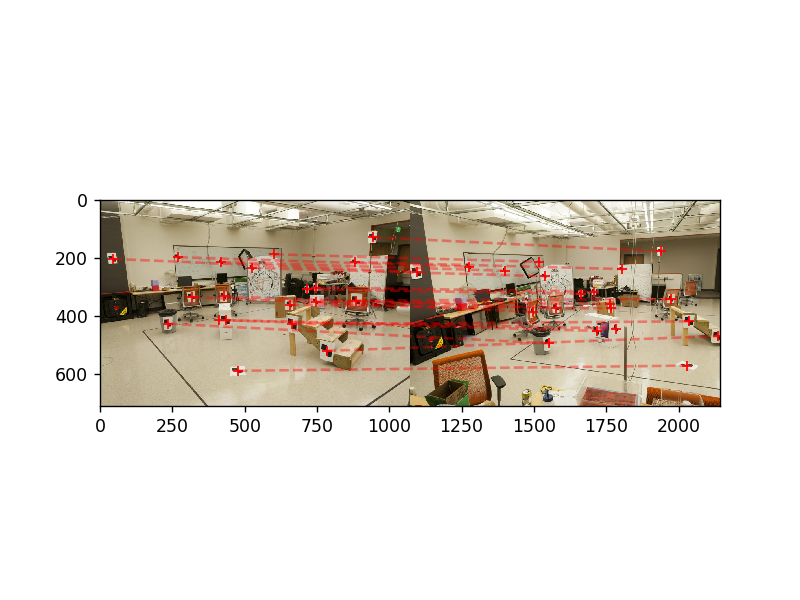

In [509]:
##
## display two images side-by-side with matches
## this code is to help you visualize the matches, you don't need
## to use it to produce the results for the assignment
##

I3_2 = np.zeros((I1_2.size[1],I1_2.size[0]*2,3) )
I3_2[:,:I1_2.size[0],:] = I1_2;
I3_2[:,I1_2.size[0]:,:] = I2_2;
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.imshow(np.uint8(np.array(I3_2)))
ax.plot(matches_2[:,0],matches_2[:,1],  '+r')
ax.plot( matches_2[:,2]+I1_2.size[0],matches_2[:,3], '+r')
ax.plot([matches_2[:,0], matches_2[:,2]+I1_2.size[0]],[matches_2[:,1], matches_2[:,3]], 'r--', alpha = 0.4)
plt.show()


Unnormalized
(20, 1) (20, 1)


<IPython.core.display.Javascript object>


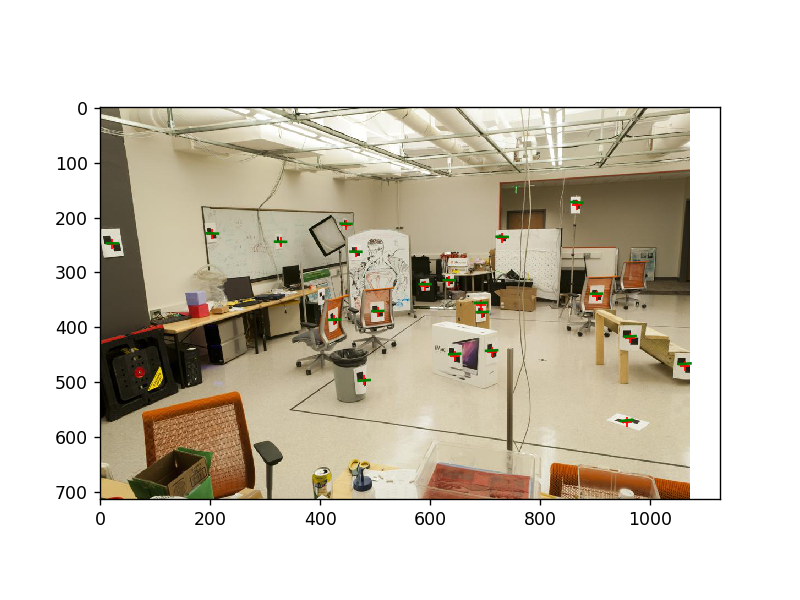

Lab Image- Unnormalized method residual =  6.567091502185167


In [502]:
#LAB IMAGE 
##
## display second image with epipolar lines reprojected 
## from the first image
##
# first, fit fundamental matrix to the matches

# FOR THE UNNORMALIZED FUNDAMENTAL MATRIX
F = fit_fundamental(matches_2, 0); # this is a function that you should write
M = np.c_[matches_2[:,0:2], np.ones((N_2,1))].transpose()
L1 = np.matmul(F, M).transpose() # transform points from 
# the first image to get epipolar lines in the second image

# find points on epipolar lines L closest to matches(:,3:4)
l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())# rescale the line
pt_line_dist = np.multiply(L, np.c_[matches_2[:,2:4], np.ones((N_2,1))]).sum(axis = 1)
closest_pt = matches_2[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())

# find endpoints of segment on epipolar line (for display purposes)
pt1 = closest_pt - np.c_[L[:,1], -L[:,0]]*10# offset from the closest point is 10 pixels
pt2 = closest_pt + np.c_[L[:,1], -L[:,0]]*10

# display points and segments of corresponding epipolar lines
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.imshow(np.uint8(np.array(I2_2)))
ax.plot(matches_2[:,2],matches_2[:,3],  '+r')
ax.plot([matches_2[:,2], closest_pt[:,0]],[matches_2[:,3], closest_pt[:,1]], 'r')
ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')
plt.show()

#Residual using unnormalized method 
print ('Lab Image- Unnormalized method residual = ',(pt_line_dist**2).mean())

Normalized Method


<IPython.core.display.Javascript object>


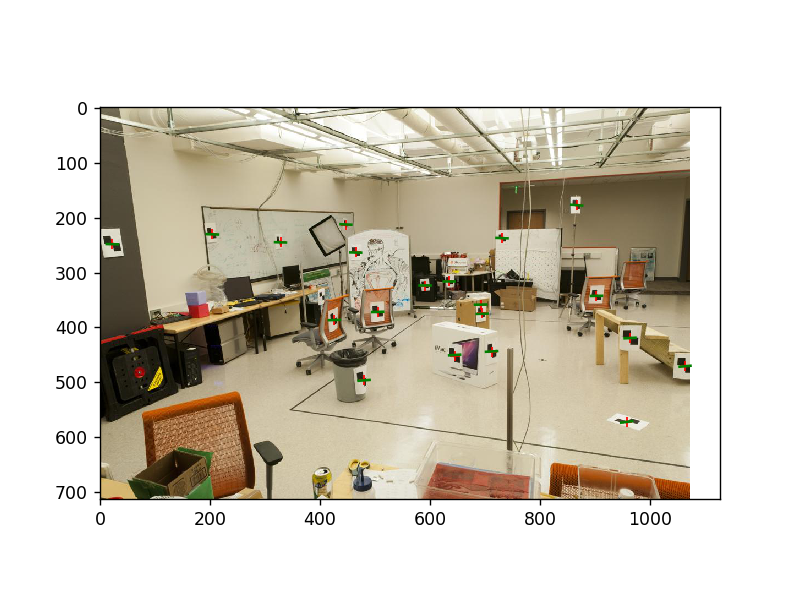

Lab Image - Normalized method residual =  0.5473984648840577


In [510]:
### FOR THE NORMALIZED FUNDAMENTAL MATRIX
F = fit_fundamental(matches_2, 1); # this is a function that you should write
M = np.c_[matches_2[:,0:2], np.ones((N_2,1))].transpose()
L1 = np.matmul(F, M).transpose() # transform points from 
# the first image to get epipolar lines in the second image

# find points on epipolar lines L closest to matches(:,3:4)
l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())# rescale the line
pt_line_dist = np.multiply(L, np.c_[matches_2[:,2:4], np.ones((N_2,1))]).sum(axis = 1)
closest_pt = matches_2[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())

# find endpoints of segment on epipolar line (for display purposes)
pt1 = closest_pt - np.c_[L[:,1], -L[:,0]]*10# offset from the closest point is 10 pixels
pt2 = closest_pt + np.c_[L[:,1], -L[:,0]]*10

# display points and segments of corresponding epipolar lines
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.imshow(np.uint8(np.array(I2_2)))
ax.plot(matches_2[:,2],matches_2[:,3],  '+r')
ax.plot([matches_2[:,2], closest_pt[:,0]],[matches_2[:,3], closest_pt[:,1]], 'r')
ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')
plt.show()

#Residual using normalized method 
print ('Lab Image - Normalized method residual = ', (pt_line_dist**2).mean())

## Part 2

In [284]:
#Part 2
#Camera calibration
#Computing the two projection matrices for lab image
#Lab Image
lab_points3D = np.loadtxt(data_dir+'lab_3d.txt')
lab_points4D = np.hstack((lab_points3D, np.ones((N_2, 1)))) #3D points in homogeneous coordinates 
zero_vector = np.zeros((1,4)) #A 4D vector of zeros
for i in range(N_2):
    row1 = np.hstack((zero_vector, lab_points4D[i].reshape(1,-1), -1*matches_2[i, 1]*lab_points4D[i].reshape(1,-1)))
    row2 = np.hstack((lab_points4D[i].reshape(1,-1), zero_vector, -1*matches_2[i, 0]*lab_points4D[i].reshape(1,-1)))
    row3 = np.hstack((zero_vector, lab_points4D[i].reshape(1,-1), -1*matches_2[i, 3]*lab_points4D[i].reshape(1,-1)))
    row4 = np.hstack((lab_points4D[i].reshape(1,-1), zero_vector, -1*matches_2[i, 2]*lab_points4D[i].reshape(1,-1)))
    
    row_lab1 = np.vstack((row1,row2))
    row_lab2 = np.vstack((row3,row4))
    
    if i==0:
        svd_matrix_1 = row_lab1
        svd_matrix_2 = row_lab2
    else:
        svd_matrix_1 = np.vstack((svd_matrix_1, row_lab1))
        svd_matrix_2 = np.vstack((svd_matrix_2, row_lab2))
        
lab1_U, lab1_S, lab1_V = np.linalg.svd(svd_matrix_1)
lab2_U, lab2_S, lab2_V = np.linalg.svd(svd_matrix_2)

lab1_projection = lab1_V[lab1_S.argmin()]
lab2_projection = lab2_V[lab2_S.argmin()]

lab1_calibrate = lab1_projection.reshape((3, 4)) #3X4 Projection matrix for lab1 image 
lab2_calibrate = lab2_projection.reshape((3, 4)) #3X4 Projection matrix for lab2 image

In [518]:
lab1_calibrate

array([[-3.09963996e-03, -1.46204548e-04,  4.48497465e-04,
         9.78930678e-01],
       [-3.07018252e-04, -6.37193664e-04,  2.77356178e-03,
         2.04144405e-01],
       [-1.67933533e-06, -2.74767684e-06,  6.83964827e-07,
         1.32882928e-03]])

In [519]:
lab2_calibrate

array([[ 6.93154686e-03, -4.01684470e-03, -1.32602928e-03,
        -8.26700554e-01],
       [ 1.54768732e-03,  1.02452760e-03, -7.27440714e-03,
        -5.62523256e-01],
       [ 7.60946050e-06,  3.70953989e-06, -1.90203244e-06,
        -3.38807712e-03]])

In [247]:
#Part 2
#Camera Caliberation evaluation
def evaluate_points(M, points_2d, points_3d):
    """
    Visualize the actual 2D points and the projected 2D points calculated from
    the projection matrix
    You do not need to modify anything in this function, although you can if you
    want to
    :param M: projection matrix 3 x 4
    :param points_2d: 2D points N x 2
    :param points_3d: 3D points N x 3
    :return:
    """
    N = len(points_3d)
    points_3d = np.hstack((points_3d, np.ones((N, 1))))
    points_3d_proj = np.dot(M, points_3d.T).T
    u = points_3d_proj[:, 0] / points_3d_proj[:, 2]
    v = points_3d_proj[:, 1] / points_3d_proj[:, 2]
    residual = np.sum(np.hypot(u-points_2d[:, 0], v-points_2d[:, 1]))
    points_3d_proj = np.hstack((u[:, np.newaxis], v[:, np.newaxis]))
    return points_3d_proj, residual

In [344]:
#Evaluating the camera calibration on lab images

#Residuals between the observed and projected 2D points for lab images 
lab1_points_2d = matches_2[:,0:2]
lab1_projected_points2D, res_1 = evaluate_points(lab1_calibrate, lab1_points_2d, lab_points3D)
print ('Residual for lab1 image = ', res_1)
print('Average squared distance for lab1 between estimated and actual 2D points = ', (np.linalg.norm(lab1_projected_points2D-lab1_points_2d, axis = 1)**2).mean())

lab2_points_2d = matches_2[:,2:4]
lab2_projected_points2D, res_2 = evaluate_points(lab2_calibrate, lab2_points_2d, lab_points3D)
print ('Residual for lab2 image = ', res_2)
print('Average squared distance for lab2 between estimated and actual 2D points = ', (np.linalg.norm(lab2_projected_points2D-lab2_points_2d, axis = 1)**2).mean())

Residual for lab1 image =  13.545832894770703
Average squared distance for lab1 between estimated and actual 2D points =  0.7861522862072994
Residual for lab2 image =  15.544953451653466
Average squared distance for lab2 between estimated and actual 2D points =  0.7456675076920227


## Part 3

#### Computing the camera centers

In [168]:
#Part 3
#Library Image
#Calculating the camera centers of the library image
library1_projection = np.loadtxt(data_dir+'library1_camera.txt')
library2_projection = np.loadtxt(data_dir+'library2_camera.txt')

#Taking the SVD of the camera projection matrix 
lib1_U, lib1_S, lib1_V = np.linalg.svd(library1_projection)
lib2_U, lib2_S, lib2_V = np.linalg.svd(library2_projection)
#Last row of V for the computed SVD
lib1_center = lib1_V[-1,:] #Homogeneous coordinates of the camera center for first library image 
lib2_center = lib2_V[-1,:] #Homogeneous coordinates of the camera center for second library image 

#Dividing the camera centers by the last coordinate to convert to non-homogeneous coordinates 
lib1_center_normalized = lib1_center/lib1_center[-1]
lib2_center_normalized = lib2_center/lib2_center[-1]

In [314]:
#Lab image 
#Calculating the camera centers of the lab image
#Taking the SVD of the camera projection matrix 
lab1_U, lab1_S, lab1_V = np.linalg.svd(lab1_calibrate)
lab2_U, lab2_S, lab2_V = np.linalg.svd(lab2_calibrate)
#Last row of V for the computed SVD
lab1_center = lab1_V[-1,:] #Homogeneous coordinates of the camera center for first library image 
lab2_center = lab2_V[-1,:] #Homogeneous coordinates of the camera center for second library image 

#Dividing the camera centers by the last coordinate to convert to non-homogeneous coordinates 
lab1_center_normalized = lab1_center/lab1_center[-1]
lab2_center_normalized = lab2_center/lab2_center[-1]

## Part 4

#### Triangulation

In [352]:
#Part 4
#Triangulation
#Use the given camera projection matrices and matching points 
#Library Image

#Solving for a 3D point for each given matching pair 
library_points_3D = []
for i in range(N):
    coeff1 = np.array([[0, -1,  matches[i, 1]], [1, 0, -matches[i, 0]], [-matches[i, 1], matches[i, 0], 0]])
    coeff2 = np.array([[0, -1,  matches[i, 3]], [1, 0, -matches[i, 2]], [-matches[i, 3], matches[i, 2], 0]])
    A1 = np.matmul(coeff1, library1_projection)
    A2 = np.matmul(coeff2, library2_projection)
    A = np.vstack((A1, A2))
    U, S, V = np.linalg.svd(A) #Solving for each 3D point corresponding to each 2D match
    point_4D = V[S.argmin()] #Taking the row with the least eigenvalue
    point_4D = point_4D/point_4D[-1] #Converting to non homogeneeous coordinates 
    library_points_3D.append(point_4D[:-1])
library_points_3D = np.array(library_points_3D)

In [316]:
#Lab Image
#Solving for a 3D point for each given matching pair 
lab_points_3D = []
for i in range(N_2):
    coeff1 = np.array([[0, -1,  matches_2[i, 1]], [1, 0, -matches_2[i, 0]], [-matches_2[i, 1], matches_2[i, 0], 0]])
    coeff2 = np.array([[0, -1,  matches_2[i, 3]], [1, 0, -matches_2[i, 2]], [-matches_2[i, 3], matches_2[i, 2], 0]])
    A1 = np.matmul(coeff1, lab1_calibrate)
    A2 = np.matmul(coeff2, lab2_calibrate)
    A = np.vstack((A1, A2))
    U, S, V = np.linalg.svd(A) #Solving for each 3D point corresponding to each 2D match
    point_4D = V[S.argmin()] #Taking the row with the least eigenvalue
    point_4D = point_4D/point_4D[-1] #Converting to non homogeneeous coordinates 
    lab_points_3D.append(point_4D[:-1])
lab_points_3D = np.array(lab_points_3D)

In [353]:
#Evaluating the camera calibration on library images
#Residuals and Average squared distance for the library image 

library1_projection = np.loadtxt(data_dir+'library1_camera.txt')
library2_projection = np.loadtxt(data_dir+'library2_camera.txt')

#Residuals between the observed and projected 2D points for lab images 
lib1_points_2d = matches[:,0:2]
lib1_projected_points2D, res_3 = evaluate_points(library1_projection, lib1_points_2d, library_points_3D)
print ('Residual for library 1 image = ', res_3)
print('Average squared distance for lab1 between estimated and actual 2D points = ', (np.linalg.norm(lib1_projected_points2D-lib1_points_2d, axis = 1)**2).mean())

lib2_points_2d = matches[:,2:4]
lib2_projected_points2D, res_4 = evaluate_points(library2_projection, lib2_points_2d, library_points_3D)
print ('Residual for library 2 image = ', res_4)
print('Average squared distance for lab2 between estimated and actual 2D points = ', (np.linalg.norm(lib2_projected_points2D-lib2_points_2d, axis = 1)**2).mean())

Residual for library 1 image =  51.532271221300746
Average squared distance for lab1 between estimated and actual 2D points =  0.07312796424284178
Residual for library 2 image =  81.28132134991958
Average squared distance for lab2 between estimated and actual 2D points =  0.26767951261762324


#### Visualizing the camera centers and the 3D triangulated points 

<IPython.core.display.Javascript object>


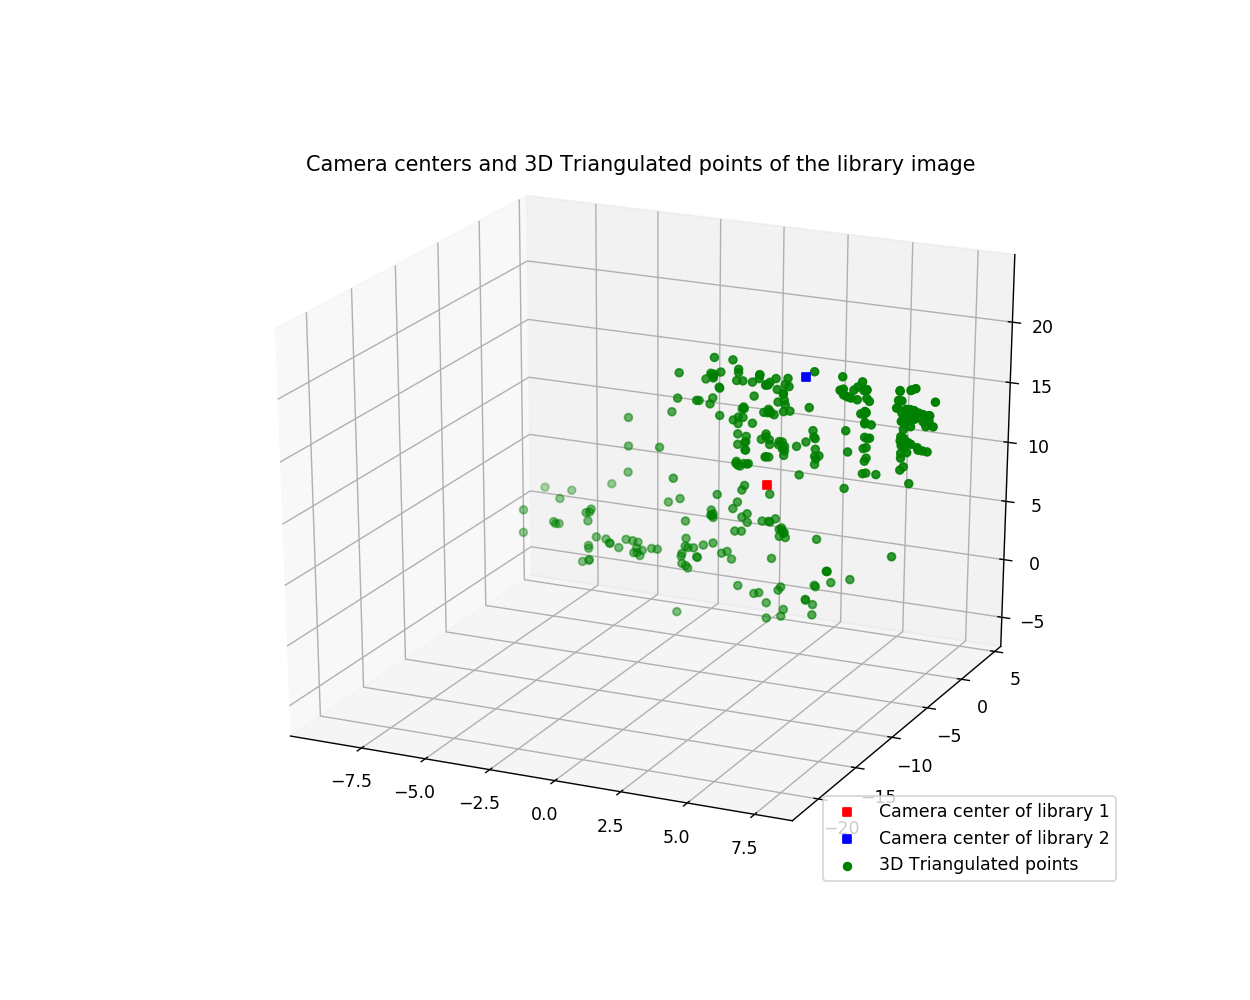

In [319]:
#Library Image
#Visualizing the camera cenetrs and the 3D triangulated points 
%matplotlib notebook
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
ax.scatter3D(lib1_center_normalized[0], lib1_center_normalized[1], lib1_center_normalized[2], label = 'Camera center of library 1', color = 'r', marker = 's')
ax.scatter3D(lib2_center_normalized[0], lib2_center_normalized[1], lib2_center_normalized[2], label = 'Camera center of library 2', color = 'b', marker = 's')
ax.scatter3D(library_points_3D[:, 0], library_points_3D[:, 1], library_points_3D[:, 2], label = '3D Triangulated points', color = 'g')
plt.legend(loc = 'lower right')
plt.title('Camera centers and 3D Triangulated points of the library image')
plt.show()

<IPython.core.display.Javascript object>


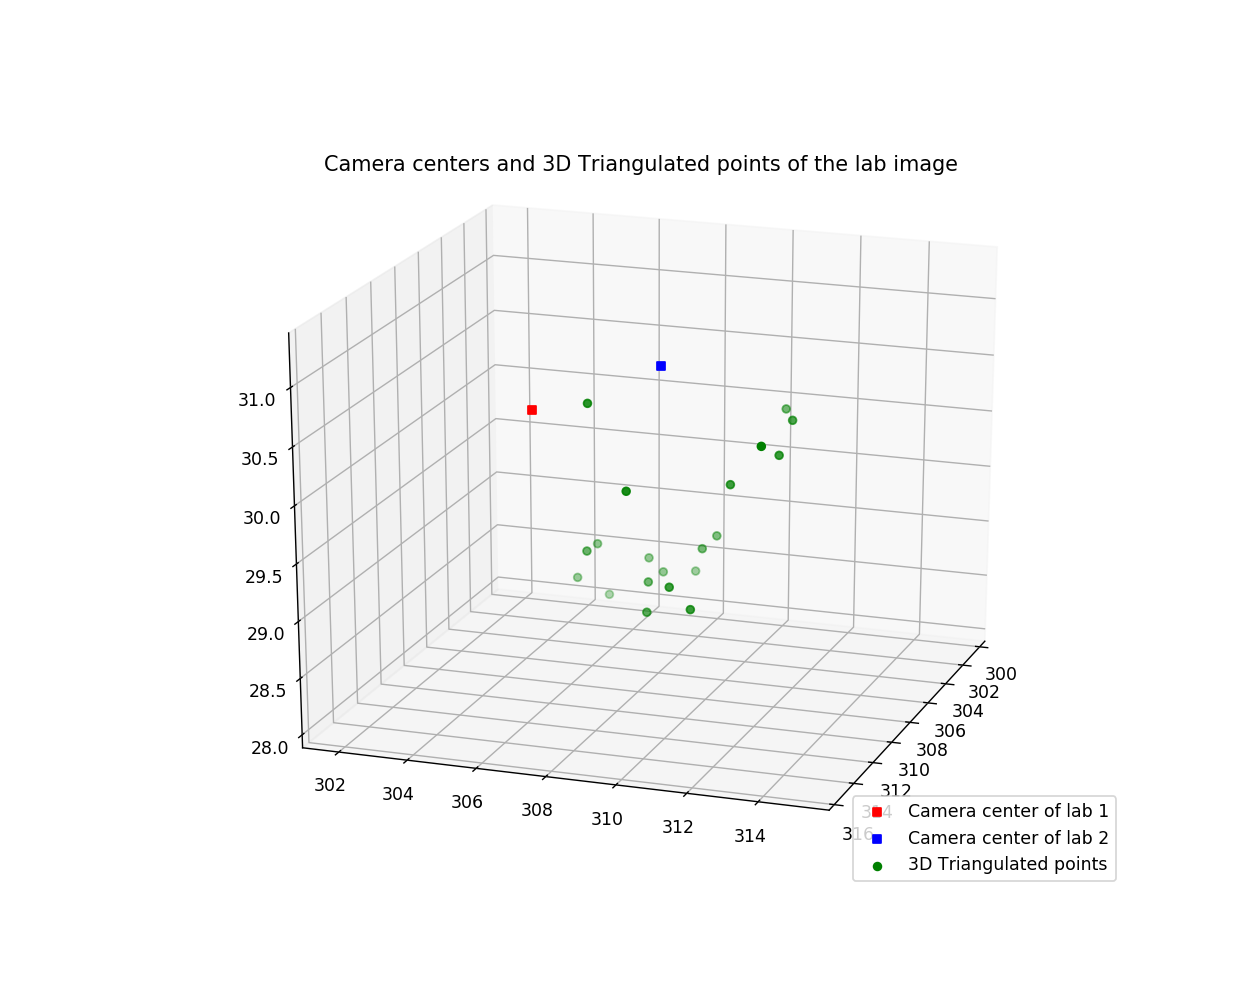

In [320]:
#Lab Image
#Visualizing the camera cenetrs and the 3D triangulated points 
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
ax.scatter3D(lab1_center_normalized[0], lab1_center_normalized[1], lab1_center_normalized[2], label = 'Camera center of lab 1', color = 'r', marker = 's')
ax.scatter3D(lab2_center_normalized[0], lab2_center_normalized[1], lab2_center_normalized[2], label = 'Camera center of lab 2', color = 'b', marker = 's')
ax.scatter3D(lab_points_3D[:, 0], lab_points_3D[:, 1], lab_points_3D[:, 2], label = '3D Triangulated points', color = 'g')
plt.legend(loc = 'lower right')
plt.title('Camera centers and 3D Triangulated points of the lab image')
plt.show()